This notebook reproduces Figure S2 in "Integrating human biophysics and data-driven analysis to assess humidity’s role in heatstroke prediction" by Kong et al.

In [1]:
"""
import python packages
please install required packages before running this notebook
"""
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# read in mean absolute prediction error of existing heat stress indices during 2020-2024
HSI_mae_2020_2024=xr.open_dataset('../data/HSI_MAE_2020-2024.nc').MAE
# read in mean absolute prediction error of GHSI during 2020-2024
GHSI_mae_2020_2024=xr.open_dataset('../data/GHSI_MAE_2020-2024.nc').MAE
# combine them into one xarray and only look at country total MAE
mae_2020_2024=xr.concat([HSI_mae_2020_2024.sum('pf'),
           GHSI_mae_2020_2024.sel(exposure='outdoor').sel(beta=1.56).sum('pf').assign_coords(HSI='GHSI').expand_dims(dim='HSI').drop(('beta','exposure')), # optimal beta=1.56 for outdoor GHSI at country level
           GHSI_mae_2020_2024.sel(exposure='indoor').sel(beta=0.98).sum('pf').assign_coords(HSI='GHSIin').expand_dims(dim='HSI').drop(('beta','exposure'))], # optimal beta=0.98 for indoor GHSI at country level
          dim='HSI',compat='override',coords='minimal')


In [3]:
# read in mean absolute prediction error of existing heat stress indices during 2010-2019
HSI_mae_2010_2019=xr.open_dataset('../data/HSI_MAE.nc').MAE
# read in mean absolute prediction error of GHSI during 2010-2019
GHSI_mae_2010_2019=xr.open_dataset('../data/GHSI_MAE.nc').MAE
# combine them into one xarray and only look at country total MAE
mae_2010_2019=xr.concat([HSI_mae_2010_2019.sum('pf'),
                         GHSI_mae_2010_2019.sel(exposure='outdoor').sel(beta=1.56).sum('pf').assign_coords(HSI='GHSI').expand_dims(dim='HSI').drop(('beta','exposure')), # optimal beta=1.56 for outdoor GHSI at country level
                         GHSI_mae_2010_2019.sel(exposure='indoor').sel(beta=0.98).sum('pf').assign_coords(HSI='GHSIin').expand_dims(dim='HSI').drop(('beta','exposure')), # optimal beta=0.98 for indoor GHSI at country level
                        ],dim='HSI').sel(HSI=mae_2020_2024['HSI'].values)



In [4]:
# rank performance
def rank(a):
    order = np.argsort(a) 
    r = np.empty_like(order)
    r[order] = np.arange(1, a.size + 1)
    return r

# performance rank of existing heat stres indices and GHSI during 2010-2019
ranks_2010_2019 = xr.apply_ufunc(
    rank, mae_2010_2019,
    input_core_dims=[['HSI']],
    output_core_dims=[['HSI']],
    vectorize=True,
).astype(int).rename('rank')

# performance rank of existing heat stres indices and GHSI during 2020-2024 
ranks_2020_2024 = xr.apply_ufunc(
    rank, mae_2020_2024,
    input_core_dims=[['HSI']],
    output_core_dims=[['HSI']],
    vectorize=True,
).astype(int).rename('rank')


<ipython-input-5-c92cc78f1655>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([r'$\mathrm{T}_{\mathrm{a}}$','HI','UTCI',r'$\mathrm{UTCI}_{\mathrm{in}}$',


Text(0.08, 0.9, 'b')

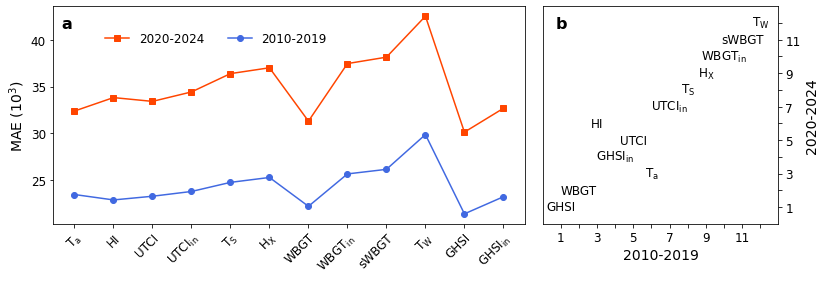

In [5]:
red='orangered'
blue = 'royalblue'
fig = plt.figure(figsize=(13,4))
gs = gridspec.GridSpec(1, 2,width_ratios=[2,1],wspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
HSI_list=['Ta','HI','UTCI','UTCIin','Ts','Hx','WBGT','WBGTin','sWBGT','Tw','GHSI','GHSIin']
ax1.plot(HSI_list,mae_2020_2024.sel(HSI=HSI_list).values*122/1000,label='2020-2024',marker='s',c=red)
ax1.plot(HSI_list,mae_2010_2019.sel(HSI=HSI_list).values*122/1000,label='2010-2019',marker='o',c=blue)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xticklabels([r'$\mathrm{T}_{\mathrm{a}}$','HI','UTCI',r'$\mathrm{UTCI}_{\mathrm{in}}$',
                     r'$\mathrm{T}_{\mathrm{S}}$',r'$\mathrm{H}_{\mathrm{X}}$','WBGT',
                     r'$\mathrm{WBGT}_{\mathrm{in}}$','sWBGT',r'$\mathrm{T}_{\mathrm{W}}$','GHSI',
                     r'$\mathrm{GHSI}_{\mathrm{in}}$'],
                    rotation=45, ha='right', rotation_mode='anchor',fontsize=12)
ax1.legend(fontsize=12,frameon=False,ncol=3,loc=(0.1,0.8))
ax1.set_ylabel('MAE '+ '('+r'$\mathrm{10}^{\mathrm{3}}$'+')',fontsize=14)

HSI_names=[r'$\mathrm{T}_{\mathrm{a}}$', 'WBGT', r'$\mathrm{WBGT}_{\mathrm{in}}$','UTCI',r'$\mathrm{H}_{\mathrm{X}}$','HI',r'$\mathrm{UTCI}_{\mathrm{in}}$',r'$\mathrm{T}_{\mathrm{W}}$','sWBGT', r'$\mathrm{T}_{\mathrm{S}}$','GHSI', r'$\mathrm{GHSI}_{\mathrm{in}}$']
for k in range(12):
    ax2.text(ranks_2010_2019[k],ranks_2020_2024[k],HSI_names[k],ha='center',va='center',fontsize=12)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax2.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])

ax2.set_xticklabels(['1','','3','','5','','7','','9','','11',''])
ax2.set_yticklabels(['1','','3','','5','','7','','9','','11',''])

ax2.set_xlim([0,13])
ax2.set_ylim([0,13])


ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlabel('2010-2019',fontsize=14)
ax2.set_ylabel('2020-2024',fontsize=14)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")  # move axis label


anno_opts = dict(xy=(0.03, 0.9), xycoords='axes fraction',va='baseline', ha='center')
ax1.annotate('a', **anno_opts,fontsize=16,fontweight='bold') 
anno_opts = dict(xy=(0.08, 0.9), xycoords='axes fraction',va='baseline', ha='center')
ax2.annotate('b', **anno_opts,fontsize=16,fontweight='bold') 

**Fig. S2.** (a) National total summer cumulative MAE of each index for 2010–2019 cross validation and 2020–2024 out-of-sample testing. (b) Comparison of performance ranks of different indices between the 2010–2019 cross validation (x-axis) and 2020–2024 out-of-sample testing (lower ranks indicate better performance).